In [68]:
%pip install tensorboard stable-baselines3 gymnasium ale-py


Note: you may need to restart the kernel to use updated packages.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object exploration_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 20.16GB > 3.23GB
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stable_baselines3/common/base_clas

Extracting features...
Applying t-SNE...
Visualizing results...


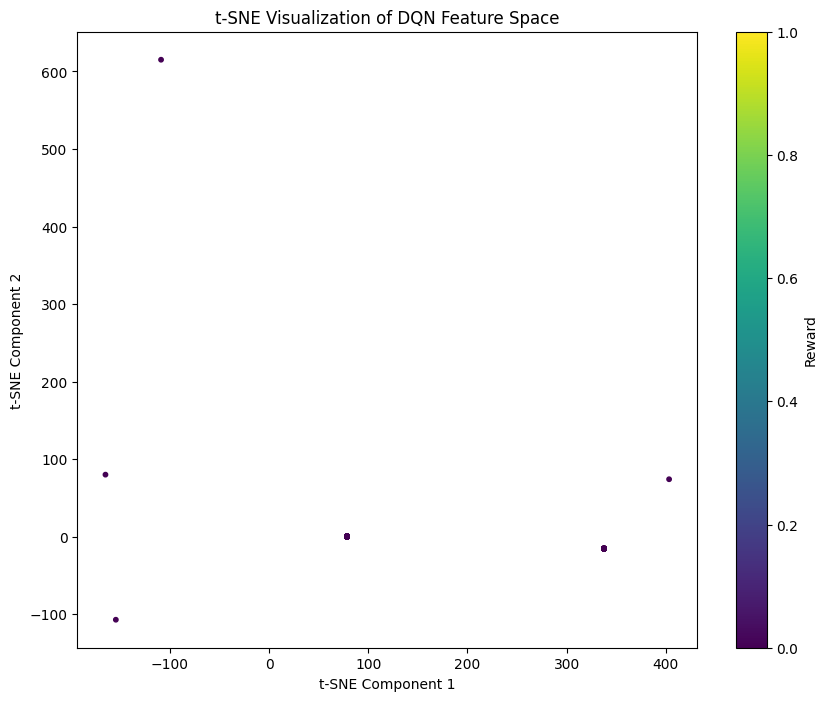

In [70]:
import gymnasium as gym
from stable_baselines3 import DQN
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import torch
from stable_baselines3.common.preprocessing import preprocess_obs

# Load the trained model
model = DQN.load("dqn_breakout")

# Create the environment
env = gym.make("ALE/Breakout-v5")

# Function to preprocess observations
def preprocess_observation(obs, model):
    # Convert to torch tensor and add batch dimension
    obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(model.device)
    # Permute dimensions to match PyTorch format [batch, channels, height, width]
    obs_tensor = obs_tensor.permute(0, 3, 1, 2)  # From [batch, height, width, channels]
    return obs_tensor / 255.0  # Normalize pixel values to [0, 1]

# Function to extract features and labels
def extract_features_and_labels(env, model, num_samples=1000):
    embeddings = []
    labels = []
    obs, _ = env.reset()
    for _ in range(num_samples):
        # Preprocess the observation
        obs_tensor = preprocess_observation(obs, model)

        # Extract features using the policy network's q_net
        with torch.no_grad():
            latent_features = model.policy.q_net(obs_tensor)  # Pass through q_net
        embeddings.append(latent_features.cpu().numpy()[0])  # Append latent features

        # Predict action and step in the environment
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, _, _ = env.step(action)
        labels.append(reward)  # Store rewards as labels

        if done:
            obs, _ = env.reset()

    return np.array(embeddings), np.array(labels)

# Extract embeddings and labels
print("Extracting features...")
embeddings, labels = extract_features_and_labels(env, model, num_samples=5000)

# Apply t-SNE using Scikit-Learn
print("Applying t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot the t-SNE visualization
print("Visualizing results...")
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', s=10
)
plt.colorbar(scatter, label="Reward")
plt.title("t-SNE Visualization of DQN Feature Space")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Close the environment
env.close()


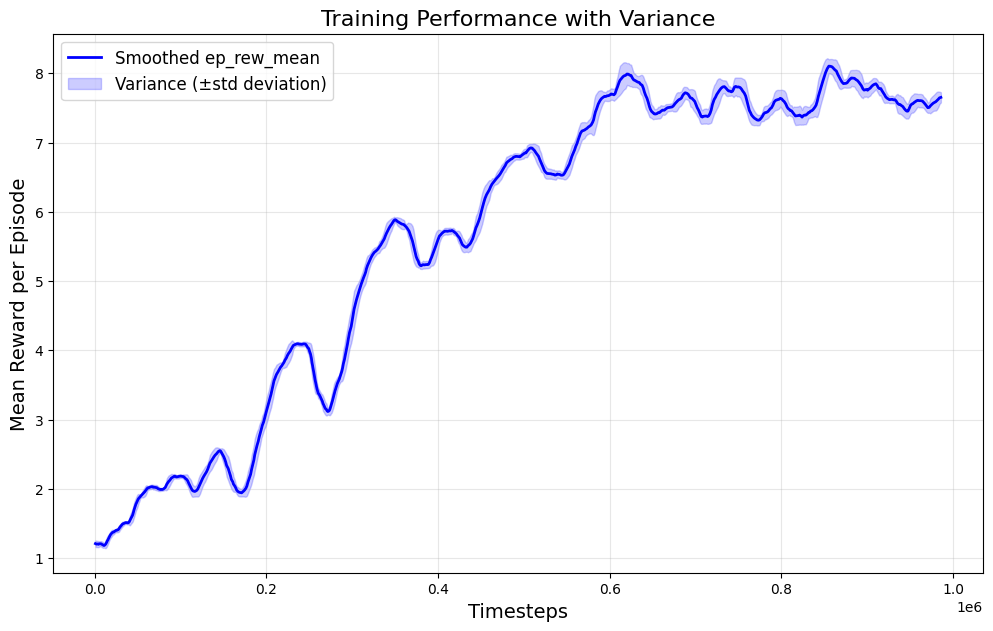

In [20]:
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import numpy as np

# Path to your TensorBoard log directory
log_dir = "./dqn_logs/DQN_1/"

# Locate the event file (assuming only one log file is in the directory)
event_files = [f for f in os.listdir(log_dir) if f.startswith("events.out")]
if not event_files:
    raise FileNotFoundError("No TensorBoard event files found in the log directory.")

# Load the event file
event_file = os.path.join(log_dir, event_files[0])
event_acc = EventAccumulator(event_file)
event_acc.Reload()  # Load the event file data

# Extract 'rollout/ep_raw_mean' data
tag = "rollout/ep_rew_mean"
if tag not in event_acc.Tags()["scalars"]:
    raise ValueError(f"Tag '{tag}' not found in TensorBoard logs.")

events = event_acc.Scalars(tag)

# Extract timesteps (X-axis) and values (Y-axis)
timesteps = [e.step for e in events]
values = [e.value for e in events]

# Calculate Moving Average and Variance
window_size = 10  # Adjust the window size as needed

def moving_average_and_variance(data, window_size):
    smoothed_values = np.convolve(data, np.ones(window_size) / window_size, mode='valid')
    variance = np.array([
        np.var(data[i:i+window_size]) for i in range(len(data) - window_size + 1)
    ])
    return smoothed_values, variance

smoothed_values, variance = moving_average_and_variance(values, window_size)

# Adjust timesteps to match the smoothed values
smoothed_timesteps = timesteps[:len(smoothed_values)]

# Plot the data using Matplotlib
plt.figure(figsize=(12, 7))

# Plot the smoothed moving average
plt.plot(smoothed_timesteps, smoothed_values, label="Smoothed ep_rew_mean", color='blue', linewidth=2)

# Plot variance as a transparent shaded region
plt.fill_between(
    smoothed_timesteps,
    smoothed_values - np.sqrt(variance),  # Lower bound
    smoothed_values + np.sqrt(variance),  # Upper bound
    color='blue',
    alpha=0.2,
    label="Variance (±std deviation)"
)

# Labels and Title
plt.xlabel("Timesteps", fontsize=14)
plt.ylabel("Mean Reward per Episode", fontsize=14)
plt.title("Training Performance with Variance", fontsize=16)

# Legend
plt.legend(fontsize=12)

# Grid
plt.grid(alpha=0.3)
plt.savefig("plot.png", dpi = 600)
# Show the plot
plt.show()



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object exploration_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 20.16GB > 3.41GB
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stable_baselines3/common/base_clas

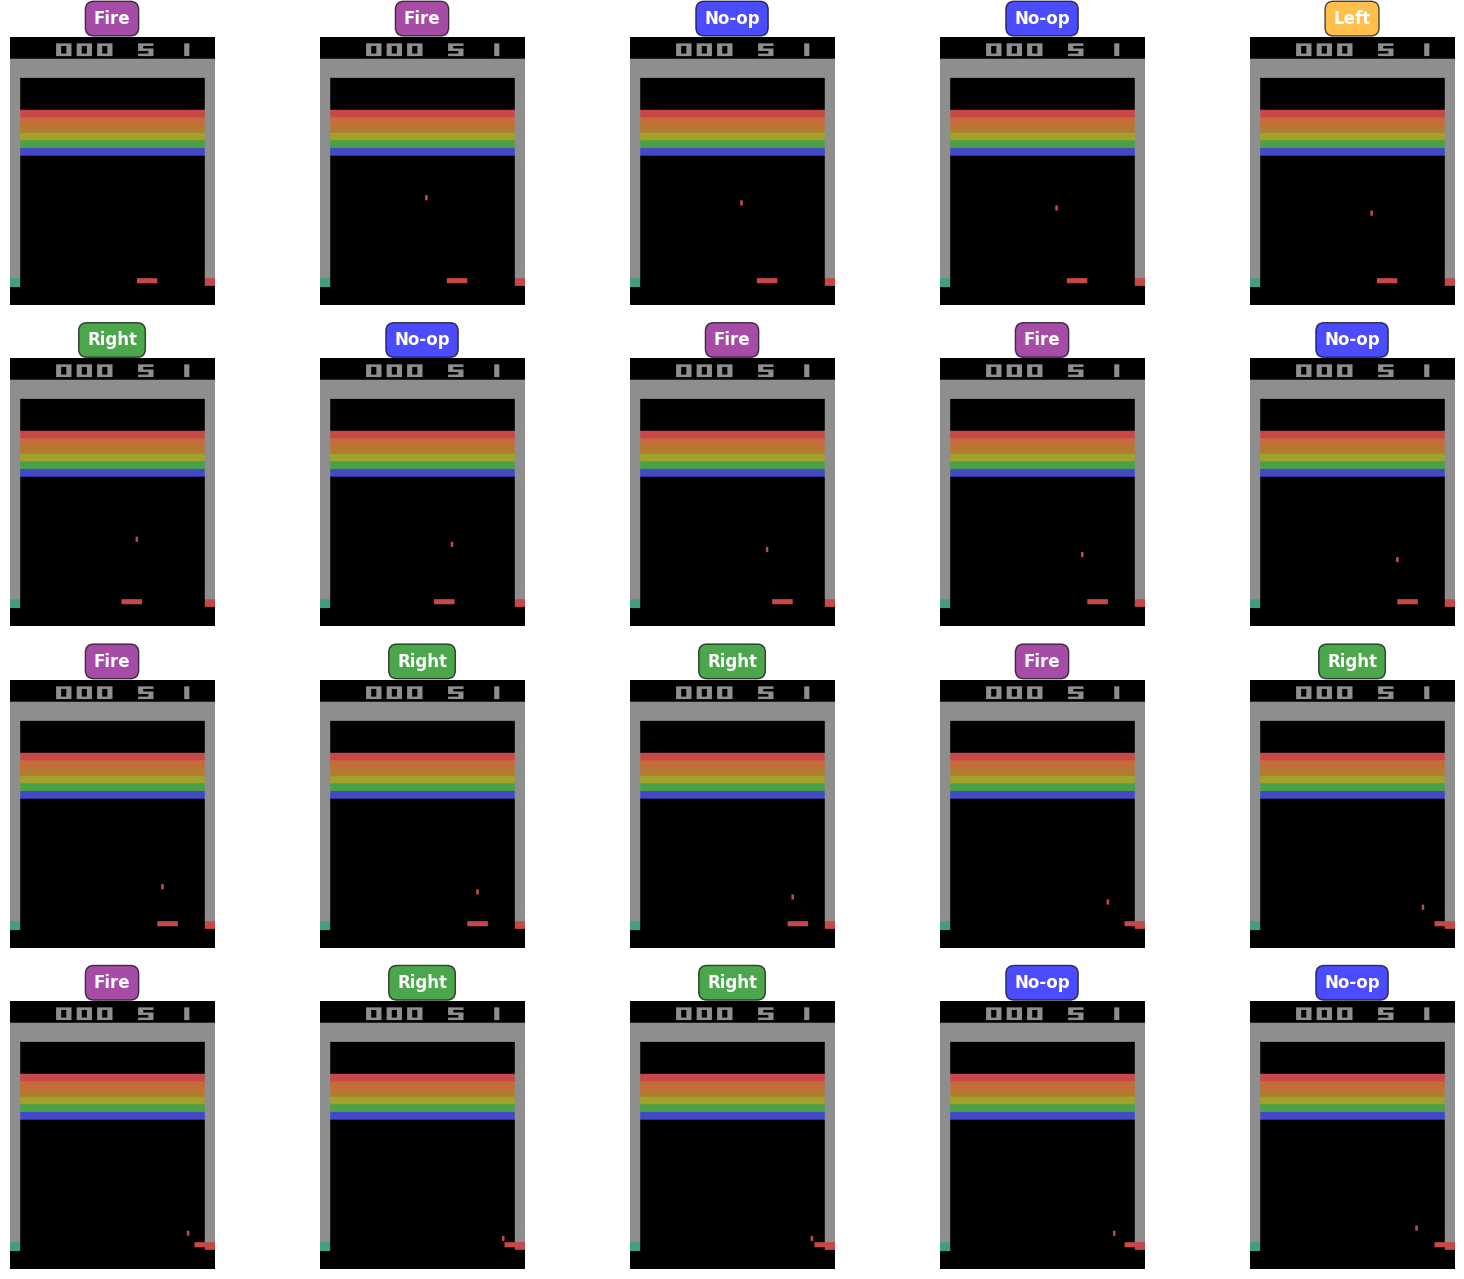

In [67]:
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.atari_wrappers import NoopResetEnv
from stable_baselines3.common.monitor import Monitor

# Load the trained model
model = DQN.load("dqn_breakout")

# Create the environment (matching training setup)
def make_env():
    def _init():
        env = gym.make("ALE/Breakout-v5", render_mode="rgb_array")
        env = NoopResetEnv(env, noop_max=30)  # No-op wrapper
        env = Monitor(env)                    # Monitoring for evaluation
        return env
    return _init

env = make_env()()

obs, info = env.reset()

# Action labels and colors for Breakout
actions = ["No-op", "Fire", "Right", "Left"]
action_colors = {"No-op": "blue", "Fire": "purple", "Right": "green", "Left": "orange"}

# Initialize variables to store frames and actions
frames = []
chosen_actions = []

# Evaluate for 20 frames and collect data
num_frames_to_visualize = 20  # Total frames to display
for i in range(num_frames_to_visualize):
    # Get the chosen action
    chosen_action, _ = model.predict(obs, deterministic=True)

    # Store the frame and chosen action
    frames.append(obs)
    chosen_actions.append(chosen_action)

    # Take the chosen action and proceed to the next frame
    obs, reward, done, truncated, info = env.step(chosen_action)

    if done or truncated:
        obs, info = env.reset()  # Restart the environment if done

# Create a 5x4 grid for visualization
fig, axes = plt.subplots(4, 5, figsize=(20, 16))  # 4 rows, 5 columns

# Adjust the spacing between rows and columns
plt.subplots_adjust(wspace=0, hspace=0.2)  # More space between rows

# Populate the grid with frames and chosen actions
for idx, ax in enumerate(axes.flat):  # Flatten the 2D grid into 1D for iteration
    if idx < num_frames_to_visualize:
        # Plot the game frame
        ax.imshow(frames[idx])
        ax.axis("off")

        # Add the chosen action text
        action_text = f"{actions[chosen_actions[idx]]}"
        ax.text(
            0.5, 1.05, action_text,
            transform=ax.transAxes,
            fontsize=12,
            color="white",
            weight="bold",
            ha="center",
            bbox=dict(facecolor=action_colors[actions[chosen_actions[idx]]], alpha=0.7, boxstyle="round,pad=0.5")
        )
    else:
        ax.axis("off")  # Turn off unused subplots

plt.savefig("1chosen_actions_grid_with_spacing.png", dpi = 600)
plt.show()
